In [1]:
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
!pip install onnxruntime

  Cloning https://github.com/jlcsilva/segmentation_models.pytorch to /tmp/pip-req-build-we5uusxh
  Running command git clone --filter=blob:none --quiet https://github.com/jlcsilva/segmentation_models.pytorch /tmp/pip-req-build-we5uusxh
  Resolved https://github.com/jlcsilva/segmentation_models.pytorch to commit 44a5593bfb1c8f2a3f5f23303c02e6f7e2f11170
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 18.3 MB/s eta 0:00:00
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=96319 sha256=de9f603e1de95e45bb639ac61cea9cb13e67e85fc315c9ffba1531f400ad753e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ugn0698/wheels/62/8f/61/617a3d940a6f738b4e551b3e97729743fd1ee4892d5ad65c44
  Created wheel for efficientnet-pytorch: fi

In [2]:
import torch
import torch.nn as nn
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import segmentation_models_pytorch as smp
import torchvision.models as models
from PIL import Image

In [3]:
!nvidia-smi

Sat Aug 10 05:44:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

In [6]:
sample_file = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train/0001TP_006690.png"
with Image.open(sample_file) as im:
  width, height = im.size

In [7]:
train_img_path = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train"
train_mask_path = "/kaggle/input/cityscape-segmentation-dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train"
train_img = os.listdir(train_img_path)
train_img = [img for img in train_img if img in os.listdir(train_mask_path)]
test_img_path = "/kaggle/input/cityscape-segmentation-dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test"
test_mask_path = "/kaggle/input/cityscape-segmentation-dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test"
test_img = os.listdir(test_img_path)
test_img = [img for img in test_img if img in os.listdir(test_mask_path)]
generator = torch.Generator().manual_seed(seed)
train_img, val_img = random_split(train_img, [0.8, 0.2], generator=generator)

In [8]:
classes = set()

for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    unique_classes = np.unique(mask_array)
    classes.update(unique_classes)
    
temp = np.zeros(len(classes))
    
for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    for cl in classes:
        count = np.sum(mask_array == cl)
        temp[cl] += count

temp = temp/np.sum(temp)
inv_weights = 1/temp
weights = torch.from_numpy(inv_weights / np.sum(inv_weights))  #could be used for loss calculation with weights

print(classes)
print(temp)
print(weights)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
[0.16894623 0.22810063 0.00978257 0.31575249 0.04566817 0.09999711
 0.0115089  0.01217829 0.05887739 0.00643389 0.00310764 0.0396467 ]
tensor([0.0071, 0.0052, 0.1223, 0.0038, 0.0262, 0.0120, 0.1039, 0.0982, 0.0203,
        0.1859, 0.3849, 0.0302], dtype=torch.float64)


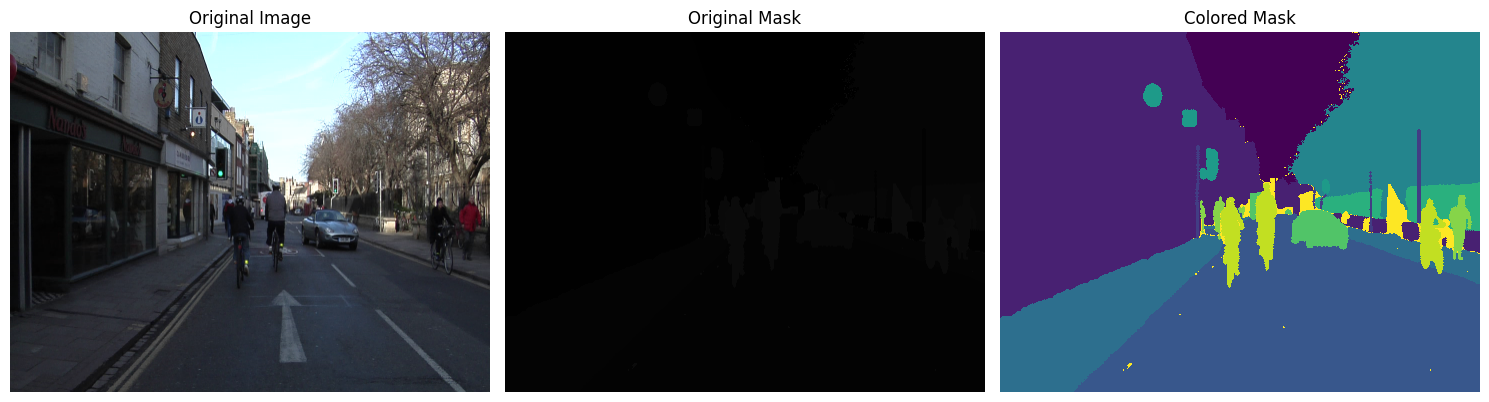

In [9]:
plt.figure(figsize=(15, 30))

sample_img = Image.open(os.path.join(test_img_path, test_img[10]))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(sample_img)
plt.axis('off')

sample_mask = Image.open(os.path.join(test_mask_path, test_img[10]))
plt.subplot(1,3,2)
plt.title("Original Mask")
plt.imshow(sample_mask, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Colored Mask")
plt.imshow(sample_mask, vmin=0, vmax=11)
plt.axis('off')

plt.tight_layout()
plt.show()

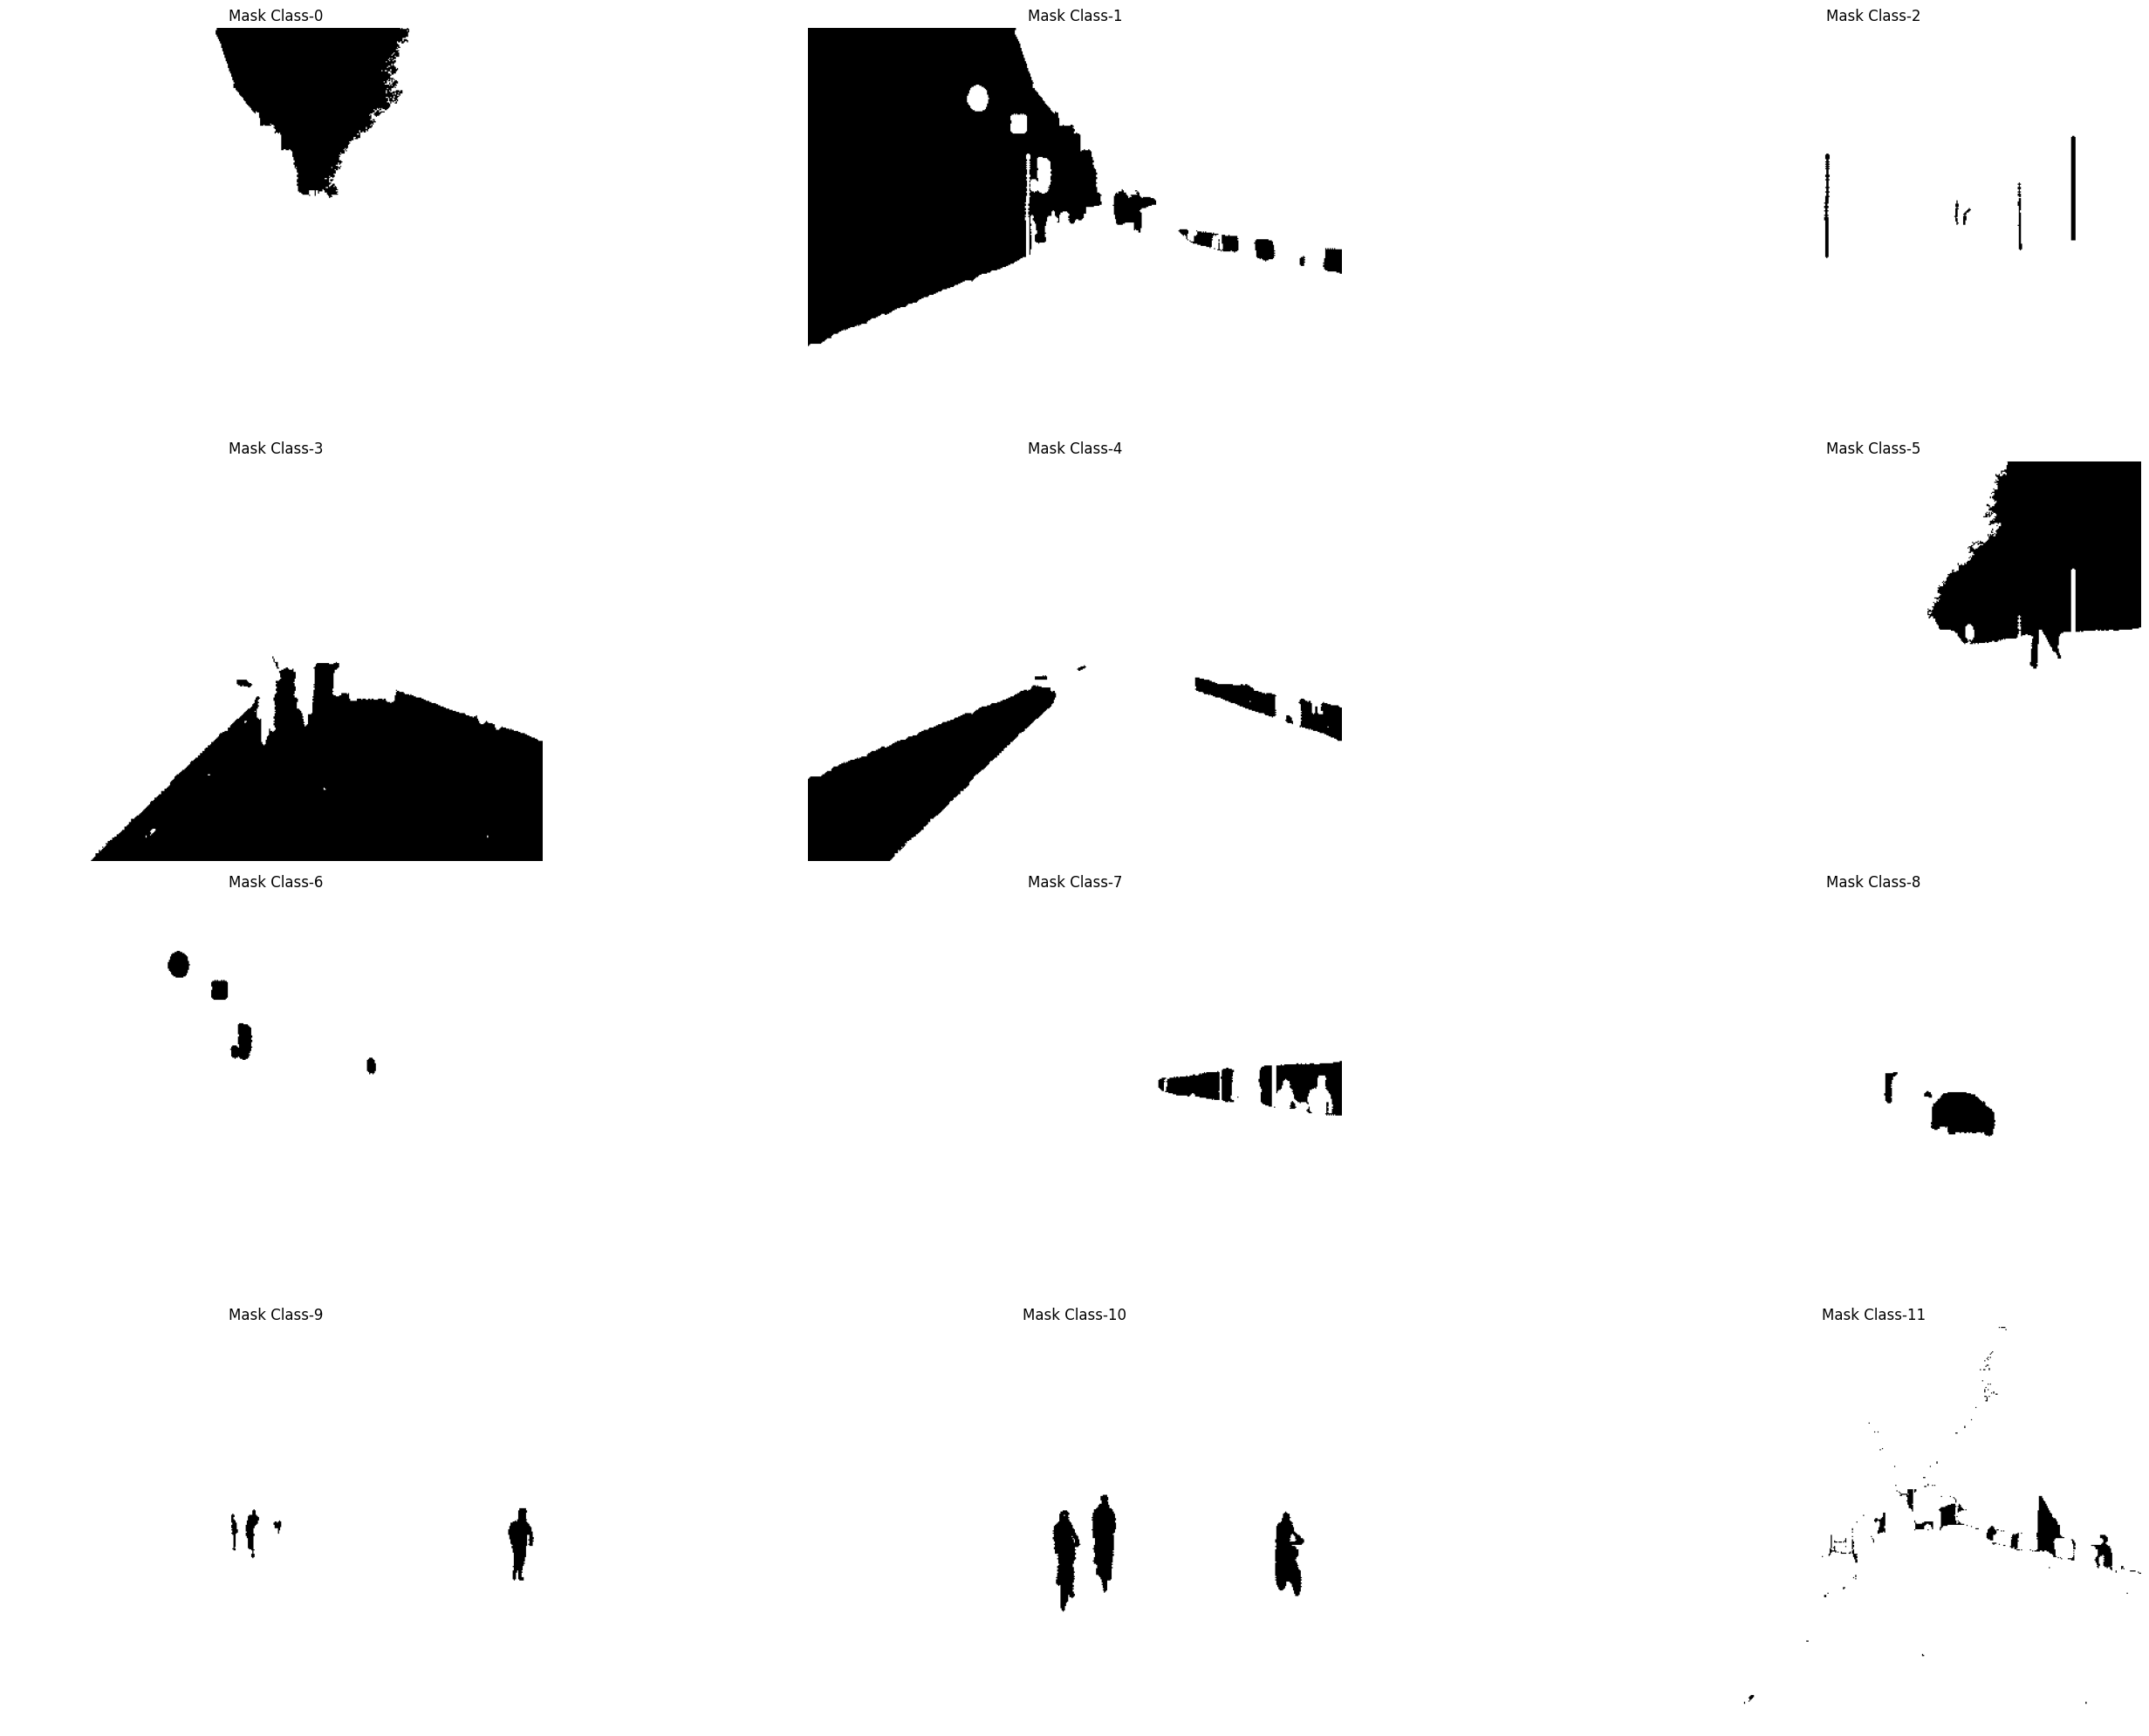

In [10]:
array = np.array(sample_mask)
plt.figure(figsize=(30, 20))
for i in classes:
    modified_array = np.where(array == i, 0, 1)
    image = Image.fromarray(modified_array.astype('uint8'))
    plt.subplot(4,3,i+1)
    plt.title(f"Mask Class-{i}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
def train_model(dataloaders, dataset_sizes, model, optimizer, criterion, scheduler=None, epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs)):
        train_running_loss = 0
        val_running_loss = 0
        model.train()
        for inputs, mask in dataloaders["train"]:
            inputs, mask = inputs.to(device), mask.to(device)
            print(inputs.shape)
            mask = mask.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, mask.long())
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        train_losses.append(train_running_loss/len(dataloaders["train"]))
        
        model.eval()
        with torch.no_grad():
            for inputs, mask in dataloaders["validation"]:
                inputs, mask = inputs.to(device), mask.to(device)
                mask = mask.squeeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, mask.long())
                val_running_loss += loss.item()
                
            val_losses.append(val_running_loss/len(dataloaders["validation"]))
        
        scheduler.step(val_running_loss/len(dataloaders["validation"]))
            
        print(f'Epoch-{epoch+1}/{epochs}')
        print(f'Training Losses: {train_running_loss/len(dataloaders["train"])}')
        print(f'Validation Losses: {val_running_loss/len(dataloaders["validation"])}')
    
    return train_losses, val_losses

In [12]:
class Dataset(Dataset):
    def __init__(self, img, image_folder_path, mask_folder_path, transform=None):
        self.img_list = img
        self.image_folder_path = image_folder_path
        self.mask_folder_path = mask_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = [os.path.join(self.image_folder_path, img) for img in self.img_list]
        mask_path = [os.path.join(self.mask_folder_path, img) for img in self.img_list]

        image = Image.open(image_path[idx])
        mask = Image.open(mask_path[idx])
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        image = transforms.ToTensor()(image)
        mask_np = np.array(mask)
        mask = torch.tensor(mask_np, dtype=torch.long)

        return image, mask

In [13]:
transform = {
    'train': transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.2),
#     transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    transforms.Resize((512,512)),
    ]),
    'val': transforms.Compose([
    transforms.Resize((512,512)),
    ]),
    'test': transforms.Compose([
    transforms.Resize((512,512)),
    ])
}

In [14]:
train_set = Dataset(train_img, image_folder_path=train_img_path, mask_folder_path=train_mask_path, transform=transform['train'])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

val_set = Dataset(val_img, image_folder_path=train_img_path, mask_folder_path=train_mask_path, transform=transform['val'])
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

test_set = Dataset(test_img, image_folder_path=test_img_path, mask_folder_path=test_mask_path, transform=transform['test'])
test_loader = DataLoader(test_set, batch_size=4, shuffle=True)

dataloaders = {
    "train":train_loader, "validation":val_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "validation":len(val_set), "test":len(test_set)
}

In [15]:
# model = models.segmentation.fcn_resnet50(num_classes=len(classes), weights_backbone='ResNet50_Weights.IMAGENET1K_V1').to(device)
model = smp.Unet(
    encoder_name="resnet34",      
    encoder_weights="imagenet", 
    decoder_channels=(512, 256, 128, 64, 32),
    in_channels=3,                
    classes=len(classes),       
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold_mode='abs', verbose=True)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 295MB/s]


In [16]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
train_losses, val_losses = train_model(dataloaders, dataset_sizes, model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=50)
torch.save({
            'epoch': 50,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/kaggle/working/UNet_ResNet_CityScape.pt")
torch.save(model.state_dict(), "/kaggle/working/UNet_ResNet_CityScape.pth")
df = pd.DataFrame({'train_losses': train_losses, 'val_losses': val_losses})
df.to_csv("/kaggle/working/UNet_ResNet_CityScape_Loss.csv")

  2%|▏         | 1/50 [00:26<21:48, 26.71s/it]

Epoch-1/50
Training Losses: 1.2754045781251546
Validation Losses: 1.1802673151618557


  4%|▍         | 2/50 [00:49<19:35, 24.49s/it]

Epoch-2/50
Training Losses: 0.9918791756436631
Validation Losses: 81.01439004195363


  6%|▌         | 3/50 [01:12<18:37, 23.77s/it]

Epoch-3/50
Training Losses: 0.9875423247749741
Validation Losses: 0.8894137928360387


  8%|▊         | 4/50 [01:35<17:58, 23.45s/it]

Epoch-4/50
Training Losses: 0.9155802831456468
Validation Losses: 1.0831451604240818


 10%|█         | 5/50 [01:58<17:24, 23.21s/it]

Epoch-5/50
Training Losses: 0.8786212181722796
Validation Losses: 0.9768633497388739


 12%|█▏        | 6/50 [02:21<16:57, 23.11s/it]

Epoch-6/50
Training Losses: 0.8241923250056602
Validation Losses: 1.0823352713333934


 14%|█▍        | 7/50 [02:44<16:32, 23.09s/it]

Epoch-7/50
Training Losses: 0.845655578213769
Validation Losses: 1.3473273139250905


 16%|█▌        | 8/50 [03:07<16:06, 23.02s/it]

Epoch-8/50
Training Losses: 0.7752016678049758
Validation Losses: 0.9170220807978982


 18%|█▊        | 9/50 [03:30<15:42, 22.98s/it]

Epoch-9/50
Training Losses: 0.7620356815892297
Validation Losses: 1.1602941939705296


 20%|██        | 10/50 [03:53<15:20, 23.01s/it]

Epoch-10/50
Training Losses: 0.710072524241499
Validation Losses: 1.091922126318279


 22%|██▏       | 11/50 [04:16<15:01, 23.10s/it]

Epoch-11/50
Training Losses: 0.6995873596217181
Validation Losses: 0.722383975982666


 24%|██▍       | 12/50 [04:39<14:37, 23.10s/it]

Epoch-12/50
Training Losses: 0.6623924000037683
Validation Losses: 0.7086579736910368


 26%|██▌       | 13/50 [05:02<14:13, 23.06s/it]

Epoch-13/50
Training Losses: 0.6892139605573706
Validation Losses: 0.7236759568515577


 28%|██▊       | 14/50 [05:25<13:48, 23.02s/it]

Epoch-14/50
Training Losses: 0.6558498526747162
Validation Losses: 0.7303837663248965


 30%|███       | 15/50 [05:48<13:24, 22.98s/it]

Epoch-15/50
Training Losses: 0.6260865620664648
Validation Losses: 1.212021413602327


 32%|███▏      | 16/50 [06:11<13:00, 22.95s/it]

Epoch-16/50
Training Losses: 0.598658650308042
Validation Losses: 1.0283249804848118


 34%|███▍      | 17/50 [06:33<12:35, 22.90s/it]

Epoch-17/50
Training Losses: 0.5965332215702212
Validation Losses: 55.661195955778425


 36%|███▌      | 18/50 [06:56<12:11, 22.85s/it]

Epoch-18/50
Training Losses: 0.6339059371400524
Validation Losses: 0.7687552383071498


 38%|███▊      | 19/50 [07:19<11:48, 22.87s/it]

Epoch-19/50
Training Losses: 0.6013116953340737
Validation Losses: 0.6663548507188496


 40%|████      | 20/50 [07:42<11:25, 22.86s/it]

Epoch-20/50
Training Losses: 0.5705696114817181
Validation Losses: 0.6023264182241339


 42%|████▏     | 21/50 [08:05<11:03, 22.87s/it]

Epoch-21/50
Training Losses: 0.5580670954407873
Validation Losses: 0.6834795506376969


 44%|████▍     | 22/50 [08:28<10:42, 22.94s/it]

Epoch-22/50
Training Losses: 0.5561421247752937
Validation Losses: 0.5867083747135965


 46%|████▌     | 23/50 [08:51<10:18, 22.90s/it]

Epoch-23/50
Training Losses: 0.5202358663082123
Validation Losses: 1.078027229560049


 48%|████▊     | 24/50 [09:14<09:55, 22.89s/it]

Epoch-24/50
Training Losses: 0.5185196975598464
Validation Losses: 19.577341544000728


 50%|█████     | 25/50 [09:36<09:30, 22.83s/it]

Epoch-25/50
Training Losses: 0.5583852767138868
Validation Losses: 0.8234467976971677


 52%|█████▏    | 26/50 [09:59<09:06, 22.77s/it]

Epoch-26/50
Training Losses: 0.5275102048306852
Validation Losses: 0.7506339863726967


 54%|█████▍    | 27/50 [10:22<08:43, 22.75s/it]

Epoch-27/50
Training Losses: 0.5015785468591226
Validation Losses: 0.5147306401478616


 56%|█████▌    | 28/50 [10:44<08:20, 22.75s/it]

Epoch-28/50
Training Losses: 0.4893269744273779
Validation Losses: 0.5739427820632332


 58%|█████▊    | 29/50 [11:07<07:57, 22.76s/it]

Epoch-29/50
Training Losses: 0.4780259337779638
Validation Losses: 0.4694348212919737


 60%|██████    | 30/50 [11:30<07:35, 22.79s/it]

Epoch-30/50
Training Losses: 0.4732131655957248
Validation Losses: 1.7405217854600203


 62%|██████▏   | 31/50 [11:53<07:12, 22.77s/it]

Epoch-31/50
Training Losses: 0.5068508592006322
Validation Losses: 0.5766927976357309


 64%|██████▍   | 32/50 [12:16<06:50, 22.81s/it]

Epoch-32/50
Training Losses: 0.4864155203104019
Validation Losses: 0.824304483438793


 66%|██████▌   | 33/50 [12:38<06:27, 22.77s/it]

Epoch-33/50
Training Losses: 0.4885578034697352
Validation Losses: 0.9151302356469003


 68%|██████▊   | 34/50 [13:01<06:04, 22.78s/it]

Epoch-34/50
Training Losses: 0.4404319730159399
Validation Losses: 0.6736387986885873


 70%|███████   | 35/50 [13:24<05:41, 22.80s/it]

Epoch-35/50
Training Losses: 0.4538691172728667
Validation Losses: 0.5045805134271321


 72%|███████▏  | 36/50 [13:47<05:18, 22.75s/it]

Epoch-36/50
Training Losses: 0.4163483200041023
Validation Losses: 0.4596668089690961


 74%|███████▍  | 37/50 [14:09<04:55, 22.76s/it]

Epoch-37/50
Training Losses: 0.4108087339916745
Validation Losses: 0.5159574417691482


 76%|███████▌  | 38/50 [14:32<04:32, 22.73s/it]

Epoch-38/50
Training Losses: 0.4024073678899456
Validation Losses: 0.4975679657961193


 78%|███████▊  | 39/50 [14:55<04:09, 22.72s/it]

Epoch-39/50
Training Losses: 0.4361844916601439
Validation Losses: 0.5921294940145392


 80%|████████  | 40/50 [15:18<03:47, 22.77s/it]

Epoch-40/50
Training Losses: 0.4093389829268327
Validation Losses: 0.437284421763922


 82%|████████▏ | 41/50 [15:41<03:25, 22.80s/it]

Epoch-41/50
Training Losses: 0.38796909797835993
Validation Losses: 0.5078335216170863


 84%|████████▍ | 42/50 [16:03<03:02, 22.77s/it]

Epoch-42/50
Training Losses: 0.3803999379679963
Validation Losses: 0.4640787479124571


 86%|████████▌ | 43/50 [16:26<02:39, 22.81s/it]

Epoch-43/50
Training Losses: 0.37383256127705444
Validation Losses: 0.4626150601788571


 88%|████████▊ | 44/50 [16:49<02:16, 22.81s/it]

Epoch-44/50
Training Losses: 0.376928798451617
Validation Losses: 0.4783027470111847


 90%|█████████ | 45/50 [17:12<01:53, 22.80s/it]

Epoch-45/50
Training Losses: 0.3592464597644033
Validation Losses: 0.5183877976317155


 92%|█████████▏| 46/50 [17:34<01:30, 22.73s/it]

Epoch-46/50
Training Losses: 0.3441016772711599
Validation Losses: 0.48060802095814753


 94%|█████████▍| 47/50 [17:57<01:08, 22.76s/it]

Epoch-47/50
Training Losses: 0.3433783728931401
Validation Losses: 0.44646818230026647


 96%|█████████▌| 48/50 [18:20<00:45, 22.77s/it]

Epoch-48/50
Training Losses: 0.32671369873994105
Validation Losses: 0.45846908186611374


 98%|█████████▊| 49/50 [18:43<00:22, 22.74s/it]

Epoch-49/50
Training Losses: 0.32594952108086767
Validation Losses: 0.46594481405458954


100%|██████████| 50/50 [19:05<00:00, 22.92s/it]

Epoch-50/50
Training Losses: 0.32224126301101735
Validation Losses: 0.42377308638472305


In [17]:
checkpoint = torch.load("/kaggle/input/unet-cityscape-training-checkpoint/UNet_ResNet_CityScape.pt")  #for further training
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# train_losses2, val_losses2 = train_model(dataloaders, dataset_sizes, model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, epochs=50)
# torch.save({
#             'epoch': 100,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, "/kaggle/working/UNet_ResNet_CityScape2.pt")
# torch.save(model.state_dict(), "/kaggle/working/UNet_ResNet_CityScape.pth")
# df = pd.DataFrame({'train_losses': train_losses2, 'val_losses': val_losses2})
# df.to_csv("/kaggle/working/UNet_ResNet_CityScape_Loss2.csv")

In [20]:
import torch.onnx

input_names = ["input"]
output_names = ["output"]
dummy_input = torch.rand(1, 3, 512, 512).to(device)
dynamic_axes = {'input': {0: 'batch_size', 2: 'width', 3: 'height'},
 'output': {0: 'batch_size', 2: 'width', 3: 'height'}} # adding names for better debugging

torch.onnx.export(
    model,
    dummy_input,
    "/kaggle/working/UNet_ResNet_CityScape.onnx",
    verbose=True,
    input_names=input_names, # the model's input names
    output_names=output_names, # the model's output names
    dynamic_axes=dynamic_axes,
    opset_version=14, # the ONNX version to export the model to
    do_constant_folding=True, # whether to execute constant folding for optimization
)

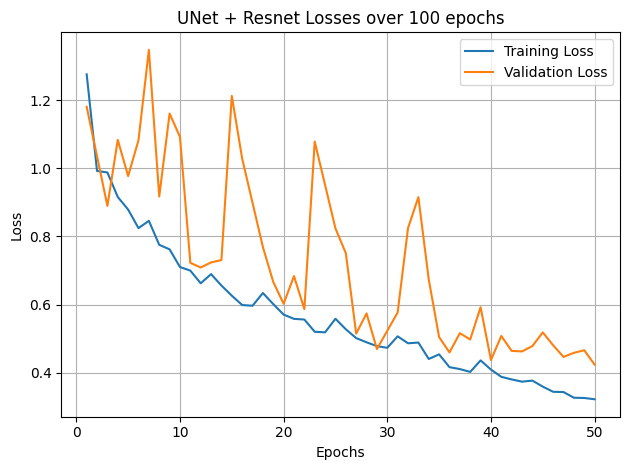

In [22]:
df = pd.read_csv('/kaggle/input/unet-cityscape-training-checkpoint/UNet_ResNet_CityScape_Loss.csv', delimiter=",")  #for further training
train_losses = df.iloc[:,1].values
val_losses = df.iloc[:,2].values  


for i, j in enumerate(val_losses):
    if j>1.4:  #1.4 is maximum acceptable loss based on curve observation
        val_losses[i] = (val_losses[i-1]+val_losses[i+1])/2  #To Eliminate Exploding Loss

plt.plot(np.linspace(1,50,50), train_losses, label='Training Loss')
plt.plot(np.linspace(1,50,50), val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('UNet + Resnet Losses over 100 epochs')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()

In [34]:
def check_accuracy(loader, model, num_classes):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score_batch = 0.0
            for cls in range(num_classes):
                preds_cls = (preds == cls).float()
                y_cls = (y == cls).float()

                intersection = (preds_cls * y_cls).sum().item()
                dice_score_batch += (2.0 * intersection) / (preds_cls.sum().item() + y_cls.sum().item() + 1e-8)

            dice_score += dice_score_batch / num_classes

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct / num_pixels * 100:.2f}")
    print(f"Dice score: {dice_score / len(loader):.4f}")


In [35]:
check_accuracy(dataloaders['test'], model, len(classes))

Got 23507206/26476544 with acc 88.79
Dice score: 0.5749


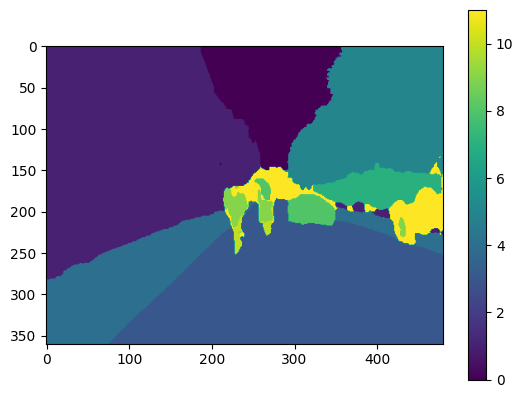

Inference Time: 0.828965319999952s
Detected Objects:
sky
building
pole
road
sidewalk
nature
sign
fence
car
person
rider
bicycle


In [36]:
import time

model.to('cpu')
model.eval()
trf = transform['test']
test_im = Image.open(os.path.join(test_img_path, test_img[10]))
img = transforms.ToTensor()(trf(test_im))
plt.imshow(test_im)
inputs = img.unsqueeze(0)

with torch.no_grad():
    start_time = time.perf_counter()
    outputs = model(inputs)
    inf_time = time.perf_counter() - start_time
    outputs = nn.Softmax2d()(outputs)
    
pred_labels = torch.argmax(outputs, dim=1) 
pred_labels = pred_labels.int()
pred_labels = pred_labels.squeeze()
pred_labels_pil = transforms.ToPILImage()(pred_labels).convert('L')
resize = transforms.Resize((height, width), interpolation=Image.NEAREST)
resized_img = resize(pred_labels_pil)

plt.imshow(resized_img, vmin=0, vmax=11)
plt.colorbar()
plt.show()
print(f"Inference Time: {inf_time}s")

det_classes = set()
obj = {
    0:"sky",
    1:"building",
    2:"pole",
    3:"road",
    4:"sidewalk",
    5:"nature",
    6:"sign",
    7:"fence",
    8:"car",
    9:"person",
    10:"rider",
    11:"bicycle"
}

for mask in train_img:
    mask_image = Image.open(os.path.join(train_mask_path, mask)).convert('L')
    mask_array = np.array(mask_image)
    unique_classes = np.unique(mask_array)
    det_classes.update(unique_classes)

print("Detected Objects:")
for key in obj:
    if key in det_classes:
        print(f"{obj[key]}")

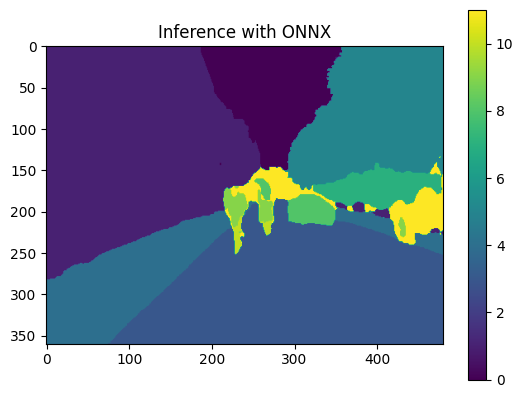

Inference Time: 0.524516801000118s


In [37]:
import onnxruntime

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

test_im = Image.open(os.path.join(test_img_path, test_img[10]))
img = transforms.ToTensor()(trf(test_im))
img = img.unsqueeze(0)

ort_session = onnxruntime.InferenceSession("/kaggle/input/unet-cityscape-training-checkpoint/UNet_ResNet_CityScape.onnx", providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
start_time = time.perf_counter()
ort_outs = ort_session.run(None, ort_inputs)
inf_time = time.perf_counter() - start_time

out = np.squeeze(np.array(ort_outs))

pred_labels = np.uint8(np.argmax(out, axis=0))
pred_labels_pil = transforms.ToPILImage()(pred_labels).convert('L')
resize = transforms.Resize((height, width), interpolation=Image.NEAREST)
resized_img = resize(pred_labels_pil)

plt.imshow(resized_img, vmin=0, vmax=11)
plt.colorbar()
plt.title("Inference with ONNX")
plt.show()
print(f"Inference Time: {inf_time}s")

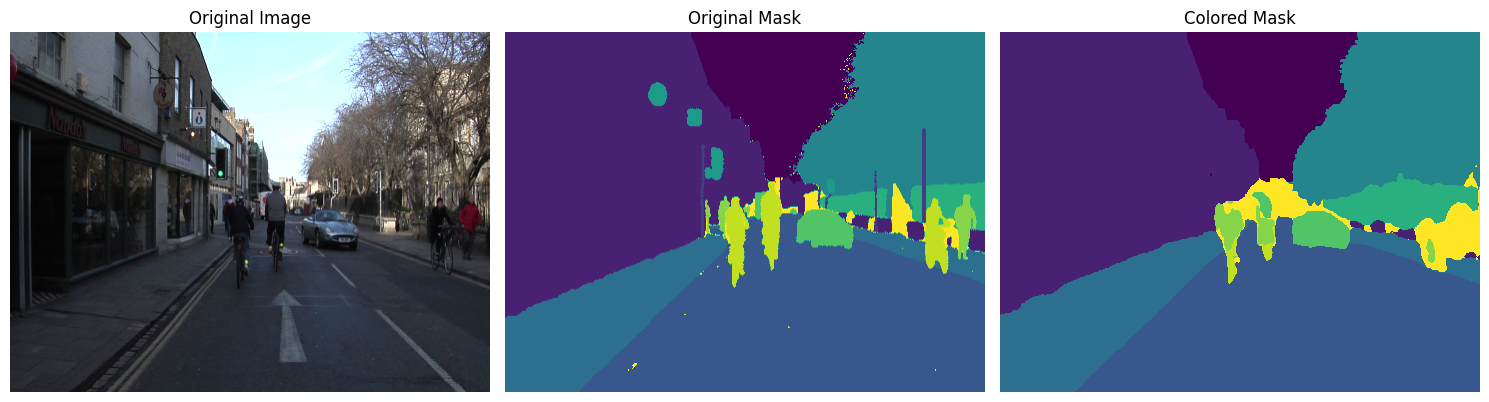

In [39]:
plt.figure(figsize=(15, 30))

sample_img = Image.open(os.path.join(test_img_path, test_img[10]))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(sample_img)
plt.axis('off')

sample_mask = Image.open(os.path.join(test_mask_path, test_img[10]))
plt.subplot(1,3,2)
plt.title("Original Mask")
plt.imshow(sample_mask)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Colored Mask")
plt.imshow(resized_img, vmin=0, vmax=11)
plt.axis('off')

plt.tight_layout()
plt.show()